# Sparse Autoencoder

## Dataset

In [23]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from tiny_imagenet import TinyImageNet

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = "MNIST"
BS = 32

if DATASET == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BS, shuffle=True)
    train_image_zero, train_target_zero = trainset[0]

elif DATASET == "CIFAR10":
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]
elif DATASET == "TINY_IMAGENET":
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = TinyImageNet(root='./data', split="train",  download=True, transform=train_transform)
    testset =  TinyImageNet(root='./data', split="val", download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

# trainloader.to(device)
# testloader.to(device)

100%|██████████| 9912422/9912422 [00:01<00:00, 9173620.68it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28862447.90it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7131836.27it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


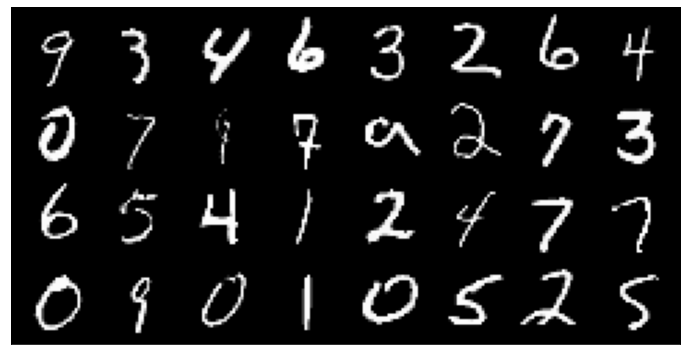

In [24]:
show_batch(trainloader)

## Model

### Model Arch

In [43]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SparseAutoencoder, self).__init__()
        self.fc1 = nn.Linear(in_dim, 512)
        self.fc2 = nn.Linear(512, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

### Train

In [48]:
from tqdm.notebook import tqdm
import torch.optim as optim

MAX_LR = 1e-3
EPOCHS = 1

model = SparseAutoencoder(
    in_dim=28 ** 2,
    out_dim=10).to(device)

optimizer = optim.Adam(
    model.parameters(),
    lr=MAX_LR)

criterion = nn.CrossEntropyLoss()

for e in range(EPOCHS):
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        images, labels = images.to(device), labels.to(device)
        images_flat = rearrange(images, 'b c h w -> b (c h w)')
        log_ps = model(images_flat)
        loss = criterion(log_ps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/1875 [00:00<?, ?it/s]

### Test

In [50]:
correct_count, all_count = 0, 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    images_flat = rearrange(images, 'b c h w -> b (c h w)')
    
    with torch.no_grad():
        logps = model(images_flat)

    _, pred = torch.max(logps, 1)
    correct_count += (pred == labels).sum().item()
    all_count += labels.size(0)

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.956
